<a href="https://colab.research.google.com/github/tqnhu2407/Color_Compression/blob/master/BERT_va_tfidf_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Importing Necessary Libraries

In [2]:
import keras

Using TensorFlow backend.


In [3]:
import os
import pandas as pd
import numpy as np
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

# Loading The Data

In [4]:
train_raw = pd.read_csv('dataset.csv', encoding='utf8')
train_raw['text'] = train_raw['text'].apply(lambda x: x.lower())
train_raw.head() # (461, 2)

,label,text
0,10,câu thành_ngữ này trong tiếng anh là a_promise...
1,2,trong một chuyến du_lịch trung_quốc chúng_tôi ...
2,10,đồng_nghiệp của tôi tổ_chức tiệc cuối tuần họ ...
3,11,một nhược_điểm lớn trong quản_lý đất_đai ở nướ...
4,0,đi trên các tuyến đường quốc_lộ ở nước ta đôi_...


# Remove _

In [5]:
def remove_underscope(text):
    texts = text.split('_')
    return ' '.join(texts)

In [6]:
train_raw['text'] = train_raw['text'].apply(remove_underscope)

# Preprocessing Data

In [7]:
train = train_raw.copy()

In [8]:
train = train.reindex(np.random.permutation(train.index))
train.head()

,label,text
180,6,ở xã thanh hương huyện thanh chương tỉnh nghệ ...
182,10,trước khi tham gia chiến trường afghanistan ch...
324,5,bác ruột tôi mất tích từ cuối tuần trước hầu h...
352,10,năm 2015 tôi mở lớp dạy học tại nhà tôi tự mua...
214,1,hơn năm trước tôi nhận được một bộ sách giáo k...


Clean the text columns

In [9]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [10]:
train['text']  = train.text.apply(clean_txt)
train.head()

,label,text
180,6,ở xã thanh hương huyện thanh chương tỉnh nghệ ...
182,10,trước khi tham gia chiến trường afghanistan ch...
324,5,bác ruột tôi mất tích từ cuối tuần trước hầu h...
352,10,năm 2015 tôi mở lớp dạy học tại nhà tôi tự mua...
214,1,hơn năm trước tôi nhận được một bộ sách giáo k...


In [11]:
from textblob import TextBlob
import nltk
import string
def text_preproc(x):
  x = x.lower()
  x = x.encode('utf8', 'ignore').decode()
  x = x.replace('\n', ' ')
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  return x

train['clean_text'] = train.text.apply(text_preproc)
train = train.sample(frac=1).reset_index(drop=True)

# Add tf-idf

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(train['clean_text']).toarray()
train_tfidf = pd.DataFrame(X_tfidf, columns=vectorizer.get_feature_names())
train_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aarhus,abbott,abe,abercrombie,abor,academic,acb,accademy,acemoglu,acetate,...,ộp,ớn,ớt,ục,ụp,ủa,ủi,ủng,ức,ứng
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022817,0.0,0.074272
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.017885
458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.013181
459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.015510


In [13]:
train_combined = pd.concat([train, train_tfidf], axis=1)

In [14]:
train_combined.head(2)

,label,text,clean_text,aarhus,abbott,abe,abercrombie,abor,academic,acb,...,ộp,ớn,ớt,ục,ụp,ủa,ủi,ủng,ức,ứng
0,4,bữa trưa của tôi thường diễn ra trên vỉa hè hà...,bữa trưa của tôi thường diễn ra trên vỉa hè hà...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022817,0.0,0.074272
1,11,lê quốc thắng viết phố xa năm 1989 vì tình cờ ...,lê quốc thắng viết phố xa năm vì tình cờ gặp b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


# New train_test_split function

In [15]:
df_labels = train_combined['label'].value_counts().index.tolist()
df_counts = train_combined['label'].value_counts().values.tolist()

train_temp = pd.DataFrame()
val_temp = pd.DataFrame()
#test_temp = pd.DataFrame()

for label, count in zip(df_labels, df_counts):
    train_count = round(count * 0.8)
    #val_count = round((count - train_count)*0.7)
    train_temp = pd.concat([train_temp, train_combined[train_combined['label']==label][:train_count]])
    val_temp = pd.concat([val_temp, train_combined[train_combined['label']==label][train_count:]])
    #test_temp = pd.concat([test_temp, train_combined[train_combined['label']==label][train_count + val_count:]])

In [16]:
train_temp.reset_index(drop=True, inplace=True)
val_temp.reset_index(drop=True, inplace=True)
#test_temp.reset_index(drop=True, inplace=True)

In [17]:
train_temp.shape, val_temp.shape#, test_temp.shape

((368, 5759), (93, 5759))

In [18]:
train_temp.head(2)

,label,text,clean_text,aarhus,abbott,abe,abercrombie,abor,academic,acb,...,ộp,ớn,ớt,ục,ụp,ủa,ủi,ủng,ức,ứng
0,1,đi xem ở đây là theo đúng nghĩa đen vì tôi kh...,đi xem ở đây là theo đúng nghĩa đen vì tôi kh...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,tôi có một thói quen sau nhiều năm viết bình l...,tôi có một thói quen sau nhiều năm viết bình l...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Seperate text and tfidf

In [19]:
train = train_temp[['label', 'text']]
val = val_temp[['label', 'text']]
#test = test_temp[['label', 'text']]

In [20]:
train.shape, val.shape

((368, 2), (93, 2))

In [21]:
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)

In [22]:
train_tfidf = train_temp.drop(columns=['label', 'text', 'clean_text'])
val_tfidf = val_temp.drop(columns=['label', 'text', 'clean_text'])
#test_tfidf = test_temp.drop(columns=['label', 'text', 'clean_text'])

In [23]:
train_tfidf.shape, val_tfidf.shape#, test_tfidf.shape

((368, 5756), (93, 5756))

# Install BERT

In [24]:
!pip install bert-tensorflow==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
# import tensorflow and tf hub to load bert model
import tensorflow as tf
import tensorflow_hub as hub

In [26]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

# Setting The Output Directory for BERT

In [27]:
# Set the output directory for saving model file
OUTPUT_DIR = 'model'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: model *****


In [28]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (368, 2)
Validation Set Shape : (93, 2)


In [29]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Splitting the Data into smaller chunks

In [30]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [31]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,label,text,text_split
0,1,đi xem ở đây là theo đúng nghĩa đen vì tôi kh...,[đi xem ở đây là theo đúng nghĩa đen vì tôi kh...
1,1,tôi có một thói quen sau nhiều năm viết bình l...,[tôi có một thói quen sau nhiều năm viết bình ...
2,1,chữ dám là một trong những từ khoá quan trọng ...,[chữ dám là một trong những từ khoá quan trọng...
3,1,theo bộ tư pháp mỹ thì công ty này đã chi hàng...,[theo bộ tư pháp mỹ thì công ty này đã chi hàn...
4,1,nhìn từ bên ngoài tôi duy trì một lối sống thị...,[nhìn từ bên ngoài tôi duy trì một lối sống th...


In [32]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,label,text,text_split
0,1,cuối tuần trước bỗng nhiên tôi tự hỏi rằng giờ...,[cuối tuần trước bỗng nhiên tôi tự hỏi rằng gi...
1,1,không dễ trả lời vì chúng ta biết quá ít về tá...,[không dễ trả lời vì chúng ta biết quá ít về t...


In [33]:
#test['text_split'] = test[DATA_COLUMN].apply(get_split)
#test.head(2)

In [34]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(2626, 2626, 2626)

In [35]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(666, 666, 666)

In [36]:
'''
test_l = []
test_label_l = []
test_index_l = []
for idx,row in test.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    test_label_l.append(row['label'])
    test_index_l.append(idx)
len(test_l), len(test_label_l), len(test_index_l)
'''

"\ntest_l = []\ntest_label_l = []\ntest_index_l = []\nfor idx,row in test.iterrows():\n  for l in row['text_split']:\n    test_l.append(l)\n    test_label_l.append(row['label'])\n    test_index_l.append(idx)\nlen(test_l), len(test_label_l), len(test_index_l)\n"

The final dataset for training:

In [37]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.shape

(2626, 2)

In [38]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df.shape

(666, 2)

In [39]:
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)

In [40]:
'''
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:test_label_l})
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.shape
'''

'\ntest_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:test_label_l})\ntest_df = test_df.sample(frac=1).reset_index(drop=True)\ntest_df.shape\n'

In [41]:
meta_train_base = train.copy()
meta_val_base = val.copy()

# BERT: Data Preprocessing 

Process the data for BERT

In [42]:
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [43]:
train_InputExamples

0       <bert.run_classifier.InputExample object at 0x...
1       <bert.run_classifier.InputExample object at 0x...
2       <bert.run_classifier.InputExample object at 0x...
3       <bert.run_classifier.InputExample object at 0x...
4       <bert.run_classifier.InputExample object at 0x...
                              ...                        
2621    <bert.run_classifier.InputExample object at 0x...
2622    <bert.run_classifier.InputExample object at 0x...
2623    <bert.run_classifier.InputExample object at 0x...
2624    <bert.run_classifier.InputExample object at 0x...
2625    <bert.run_classifier.InputExample object at 0x...
Length: 2626, dtype: object

In [44]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  tin chắc rằng nếu chúng ta tiếp tục bám sát những nguyên tắc của mình kiểm soát tốt luồng di cư từ bên ngoài vào nội địa con virus quái ác sẽ khó xâm phạm và làm đảo lộn cuộc sống tạm yên bình này lo lắng và hy vọng lớn nhất của tôi là niềm tin chống dịch vào hệ thống y tế vừa nhen nhóm sẽ không bị kéo đổ do những con sâu làm rầu nồi canh như những vụ bắt bớ vì sai phạm không liên quan đến hoạt động chuyên môn của các vị giám đốc vài bệnh viện lãnh đạo cdc hay những dòng người nhập cảnh tiểu ngạch đang kéo về trước tết sẽ trong tầm kiểm soát quay lại việc thử nghiệm vaccine made in vietnam mà tôi được dự lễ khởi động hôm qua hy vọng thử nghiệm lâm sàng sẽ thành công chúng ta vẫn đang đi đúng chiến lược đã vạch ra đóng cửa với các nước có kiểm soát cách ly cho đến khi vaccine phát huy hiệu quả ở năm covid thứ hai này chúng ta vẫn sẽ có những ca lây nhiễm lọt ra cộng đồng

__________
Row 0 - text_b of trai

# BERT: Loading the pre-trained model

In [45]:
# This is a path to an uncased (all lowercase) version of BERT
# BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [46]:
len(tokenizer.vocab.keys())

119547

In [47]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['tin', 'ch', '##ắc', 'rằng', 'nếu', 'chúng', 'ta', 'tiếp', 'tục', 'bá', '##m', 'sát', 'những', 'nguyên', 'tắc', 'của', 'mình', 'kiểm', 'soát', 'tốt', 'lu', '##ồng', 'di', 'cư', 'từ', 'bên', 'ngoài', 'vào', 'nội', 'địa', 'con', 'virus', 'quá', '##i', 'á', '##c', 'sẽ', 'khó', 'xâm', 'phạm', 'và', 'làm', 'đảo', 'lộ', '##n', 'cuộc', 'sống', 'tạm', 'y', '##ên', 'bình', 'này', 'lo', 'l', '##ắng', 'và', 'hy', 'vọng', 'lớn', 'nhất', 'của', 'tôi', 'là', 'ni', '##ềm', 'tin', 'chống', 'dịch', 'vào', 'hệ', 'thống', 'y', 'tế', 'vừa', 'n', '##hen', 'nhóm', 'sẽ', 'không', 'bị', 'kéo', 'đổ', 'do', 'những', 'con', 'sâu', 'làm', 'r', '##ầu', 'n', '##ồi', 'can', '##h', 'như', 'những', 'vụ', 'bắt', 'b', '##ớ', 'vì', 'sai', 'phạm', 'không', 'liên', 'quan', 'đến', 'hoạt', 'động', 'chuyên', 'môn', 'của', 'các', 'vị', 'giám', 'đốc', 'vài', 'bệnh', 'viện', 'lãnh', 'đạo', 'cd', '##c', 'hay', 'những', 'dòng', 'người', 'nhập', 'cảnh', 'tiểu', 'ng', '##ạch', 'đang', 'kéo', 'về', 'trước', 'tế', '##t', 'sẽ', 'trong

In [48]:
MAX_SEQ_LENGTH = 200

In [49]:
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 2626


INFO:tensorflow:Writing example 0 of 2626


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] tin ch ##ắc rằng nếu chúng ta tiếp tục bá ##m sát những nguyên tắc của mình kiểm soát tốt lu ##ồng di cư từ bên ngoài vào nội địa con virus quá ##i á ##c sẽ khó xâm phạm và làm đảo lộ ##n cuộc sống tạm y ##ên bình này lo l ##ắng và hy vọng lớn nhất của tôi là ni ##ềm tin chống dịch vào hệ thống y tế vừa n ##hen nhóm sẽ không bị kéo đổ do những con sâu làm r ##ầu n ##ồi can ##h như những vụ bắt b ##ớ vì sai phạm không liên quan đến hoạt động chuyên môn của các vị giám đốc vài bệnh viện lãnh đạo cd ##c hay những dòng người nhập cảnh tiểu ng ##ạch đang kéo về trước tế ##t sẽ trong tầm kiểm soát quay lại việc thử nghiệm va ##cci ##ne made in vie ##tna ##m mà tôi được dự lễ khởi động hôm qua hy vọng thử nghiệm lâm s ##àng sẽ thành công chúng ta vẫn đang đi đúng chiến lược đã v ##ạch ra đóng cửa với các nước có kiểm soát cách ly cho đến [SEP]


INFO:tensorflow:tokens: [CLS] tin ch ##ắc rằng nếu chúng ta tiếp tục bá ##m sát những nguyên tắc của mình kiểm soát tốt lu ##ồng di cư từ bên ngoài vào nội địa con virus quá ##i á ##c sẽ khó xâm phạm và làm đảo lộ ##n cuộc sống tạm y ##ên bình này lo l ##ắng và hy vọng lớn nhất của tôi là ni ##ềm tin chống dịch vào hệ thống y tế vừa n ##hen nhóm sẽ không bị kéo đổ do những con sâu làm r ##ầu n ##ồi can ##h như những vụ bắt b ##ớ vì sai phạm không liên quan đến hoạt động chuyên môn của các vị giám đốc vài bệnh viện lãnh đạo cd ##c hay những dòng người nhập cảnh tiểu ng ##ạch đang kéo về trước tế ##t sẽ trong tầm kiểm soát quay lại việc thử nghiệm va ##cci ##ne made in vie ##tna ##m mà tôi được dự lễ khởi động hôm qua hy vọng thử nghiệm lâm s ##àng sẽ thành công chúng ta vẫn đang đi đúng chiến lược đã v ##ạch ra đóng cửa với các nước có kiểm soát cách ly cho đến [SEP]


INFO:tensorflow:input_ids: 101 21629 18643 36228 16487 41800 18097 11057 16948 26454 74686 10147 25133 11934 22862 96723 10447 17830 43229 64520 33598 14657 37622 10120 34954 11840 24429 25331 11603 35498 18495 10173 20399 27261 10116 255 10350 16807 54155 75956 50816 10432 12984 22587 43993 10115 15625 17135 105463 193 20270 20438 10789 10406 180 55628 10432 15165 73429 15731 13346 10447 40813 10331 10414 67060 21629 28237 22654 11603 18310 16805 193 17105 60644 182 14786 24770 16807 11755 12505 47598 48424 10149 11934 10173 53752 12984 186 59328 182 36825 10944 10237 12552 11934 17790 18019 170 111585 17819 13410 50816 11755 20419 12522 12002 21364 13254 39589 52698 10447 10792 15598 45642 45529 43069 32686 27805 30608 20471 42076 10350 13605 11934 40563 11027 26785 33266 20269 10743 29372 21080 47598 12420 16325 17105 10123 16807 10504 75346 43229 64520 39174 13148 14331 63572 42788 10321 28217 10238 11019 10106 13772 34247 10147 15542 40813 10476 24467 40824 50376 13254 108113 1451

INFO:tensorflow:input_ids: 101 21629 18643 36228 16487 41800 18097 11057 16948 26454 74686 10147 25133 11934 22862 96723 10447 17830 43229 64520 33598 14657 37622 10120 34954 11840 24429 25331 11603 35498 18495 10173 20399 27261 10116 255 10350 16807 54155 75956 50816 10432 12984 22587 43993 10115 15625 17135 105463 193 20270 20438 10789 10406 180 55628 10432 15165 73429 15731 13346 10447 40813 10331 10414 67060 21629 28237 22654 11603 18310 16805 193 17105 60644 182 14786 24770 16807 11755 12505 47598 48424 10149 11934 10173 53752 12984 186 59328 182 36825 10944 10237 12552 11934 17790 18019 170 111585 17819 13410 50816 11755 20419 12522 12002 21364 13254 39589 52698 10447 10792 15598 45642 45529 43069 32686 27805 30608 20471 42076 10350 13605 11934 40563 11027 26785 33266 20269 10743 29372 21080 47598 12420 16325 17105 10123 16807 10504 75346 43229 64520 39174 13148 14331 63572 42788 10321 28217 10238 11019 10106 13772 34247 10147 15542 40813 10476 24467 40824 50376 13254 108113 1451

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 12 (id = 12)


INFO:tensorflow:label: 12 (id = 12)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] thủ trưởng mới tôi ng ##ồi đ ##ợi một lúc người cá ##n bộ g ##ầy nhỏ trên mặt đe ##o c ##ặp đ ##ít cha ##i d ##ầy bước vào ch ##ị nhân viên nói qua về trường hợp này từ s ##ài g ##òn ra tất nhiên là tôi biết ch ##áu phải đi học rồi ông bảo cô để lại giấy khai sinh của ch ##áu và đơn đề nghị cấp s ##ổ mới có thể viết tay gửi công an quận hơn một tuần sau tôi quay lại nhận s ##ổ hộ khẩu vừa k ##ị ##p xin cho con vào trường cấp một mùa hè năm ấy mỗi lần phải dùng đến s ##ổ hộ khẩu tôi thường nghĩ đến hai vị cá ##n bộ một người dá ##ng d ##ấp quyền u ##y và l ##ạnh lẽ ##o và vị ki ##a tr ##ông kiểu kiểu giáo viên ở tỉnh d ##ường như một người chỉ xử lý việc cho dân nếu dân chứng minh được rằng cá ##n bộ của họ bằng cây b ##út mực đen đã viết sai tên còn một người nhìn ra đ ##ứa trẻ bị viết [SEP]


INFO:tensorflow:tokens: [CLS] thủ trưởng mới tôi ng ##ồi đ ##ợi một lúc người cá ##n bộ g ##ầy nhỏ trên mặt đe ##o c ##ặp đ ##ít cha ##i d ##ầy bước vào ch ##ị nhân viên nói qua về trường hợp này từ s ##ài g ##òn ra tất nhiên là tôi biết ch ##áu phải đi học rồi ông bảo cô để lại giấy khai sinh của ch ##áu và đơn đề nghị cấp s ##ổ mới có thể viết tay gửi công an quận hơn một tuần sau tôi quay lại nhận s ##ổ hộ khẩu vừa k ##ị ##p xin cho con vào trường cấp một mùa hè năm ấy mỗi lần phải dùng đến s ##ổ hộ khẩu tôi thường nghĩ đến hai vị cá ##n bộ một người dá ##ng d ##ấp quyền u ##y và l ##ạnh lẽ ##o và vị ki ##a tr ##ông kiểu kiểu giáo viên ở tỉnh d ##ường như một người chỉ xử lý việc cho dân nếu dân chứng minh được rằng cá ##n bộ của họ bằng cây b ##út mực đen đã viết sai tên còn một người nhìn ra đ ##ứa trẻ bị viết [SEP]


INFO:tensorflow:input_ids: 101 18755 22380 18652 40813 10743 36825 299 53725 10417 28298 11027 23664 10115 13848 175 64761 23034 12598 20047 79212 10133 171 75669 299 25462 18939 10116 172 64761 71093 11603 18643 30324 14694 15202 22072 14517 12420 16188 16117 10789 11840 187 41501 175 40500 11859 31734 17685 10331 40813 21820 18643 12163 15723 16895 11125 36827 12660 22916 20360 12460 13148 106721 37949 14422 10447 18643 12163 10432 22400 20192 40352 18928 187 51417 18652 10601 12334 24957 30562 79100 12319 10151 22783 14789 10417 37716 11731 40813 39174 13148 16638 187 51417 29418 43377 60644 179 30324 10410 77178 11257 10173 11603 16188 18928 10417 27637 103096 10558 52256 31504 18581 15723 22344 12002 187 51417 29418 43377 40813 16591 98583 12002 13080 15598 23664 10115 13848 10417 11027 27101 10376 172 53626 17992 189 10157 10432 180 55572 93346 10133 10432 15598 10879 10113 32221 32276 56790 56790 18668 15202 1682 14221 172 38259 12552 10417 11027 14294 59324 17522 14331 11257 12

INFO:tensorflow:input_ids: 101 18755 22380 18652 40813 10743 36825 299 53725 10417 28298 11027 23664 10115 13848 175 64761 23034 12598 20047 79212 10133 171 75669 299 25462 18939 10116 172 64761 71093 11603 18643 30324 14694 15202 22072 14517 12420 16188 16117 10789 11840 187 41501 175 40500 11859 31734 17685 10331 40813 21820 18643 12163 15723 16895 11125 36827 12660 22916 20360 12460 13148 106721 37949 14422 10447 18643 12163 10432 22400 20192 40352 18928 187 51417 18652 10601 12334 24957 30562 79100 12319 10151 22783 14789 10417 37716 11731 40813 39174 13148 16638 187 51417 29418 43377 60644 179 30324 10410 77178 11257 10173 11603 16188 18928 10417 27637 103096 10558 52256 31504 18581 15723 22344 12002 187 51417 29418 43377 40813 16591 98583 12002 13080 15598 23664 10115 13848 10417 11027 27101 10376 172 53626 17992 189 10157 10432 180 55572 93346 10133 10432 15598 10879 10113 32221 32276 56790 56790 18668 15202 1682 14221 172 38259 12552 10417 11027 14294 59324 17522 14331 11257 12

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 8 (id = 8)


INFO:tensorflow:label: 8 (id = 8)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] quá tải có khi 4 5 ch ##áu phải nằm chung một gi ##ường số bệnh nhân nặng do sở ##i biến chứng ngày nào cũng có bệnh nhân đông đến mức tr ##àn ra cả hành lang các bác sĩ trực x ##ong vẫn phải ở lại làm việc mà không dá ##m nghỉ b ##ù m ##ấy tháng trời nhân viên y tế m ##ệt m ##ỏ ##i với bệnh nhân sở ##i ngày một đông điều đó k ##h ##ẳng định ngành y không h ##ề l ##ơ là với dịch bệnh nhưng câu hỏi đặt ra vậy đ ##âu là nguyên nhân làm cho bệnh sở ##i b ##ùng phát h ##ã ##y nhớ lại vụ ti ##êm chủng v ##ắc xin vi ##êm gan b cho 3 ch ##áu bé sơ sinh bị tử von ##g ở quảng trị khi đó truyền thông vào cuộc một số bài báo đã thổ ##i b ##ùng lên ng ##ọn lửa d ##ư luận hậu quả là nhiều người dân sợ h ##ãi ti ##êm v ##ắc xin coi v ##ắc xin như thuốc độc giết người bản thân tôi là một bác sĩ vậy mà [SEP]


INFO:tensorflow:tokens: [CLS] quá tải có khi 4 5 ch ##áu phải nằm chung một gi ##ường số bệnh nhân nặng do sở ##i biến chứng ngày nào cũng có bệnh nhân đông đến mức tr ##àn ra cả hành lang các bác sĩ trực x ##ong vẫn phải ở lại làm việc mà không dá ##m nghỉ b ##ù m ##ấy tháng trời nhân viên y tế m ##ệt m ##ỏ ##i với bệnh nhân sở ##i ngày một đông điều đó k ##h ##ẳng định ngành y không h ##ề l ##ơ là với dịch bệnh nhưng câu hỏi đặt ra vậy đ ##âu là nguyên nhân làm cho bệnh sở ##i b ##ùng phát h ##ã ##y nhớ lại vụ ti ##êm chủng v ##ắc xin vi ##êm gan b cho 3 ch ##áu bé sơ sinh bị tử von ##g ở quảng trị khi đó truyền thông vào cuộc một số bài báo đã thổ ##i b ##ùng lên ng ##ọn lửa d ##ư luận hậu quả là nhiều người dân sợ h ##ãi ti ##êm v ##ắc xin coi v ##ắc xin như thuốc độc giết người bản thân tôi là một bác sĩ vậy mà [SEP]


INFO:tensorflow:input_ids: 101 27261 56968 10601 12072 125 126 18643 12163 15723 21152 30404 10417 38356 38259 11634 32686 14694 47428 10149 28077 10116 23719 34445 12137 27258 13284 10601 32686 14694 23164 12002 46417 32221 22039 11859 16125 13910 12603 10792 98709 18228 34270 192 13891 22666 15723 1682 13148 12984 14331 15542 11755 27101 10147 103387 170 13580 181 48215 11642 68121 14694 15202 193 17105 181 30097 181 36091 10116 11182 32686 14694 28077 10116 12137 10417 23164 16391 12393 179 10237 73882 15027 49257 193 11755 176 43021 180 45085 10331 11182 22654 32686 15662 33046 66229 23568 11859 31811 299 28345 10331 22862 14694 12984 11257 32686 28077 10116 170 27787 13803 176 18001 10157 90290 13148 17790 14382 24495 58675 190 36228 77178 13956 24495 13412 170 11257 124 18643 12163 29045 81128 14422 12505 20939 10166 10240 1682 101707 18327 12072 12393 20967 18030 11603 15625 10417 11634 23935 24276 11213 50546 10116 170 27787 16732 10743 34979 50718 172 28776 43769 25717 25308 1

INFO:tensorflow:input_ids: 101 27261 56968 10601 12072 125 126 18643 12163 15723 21152 30404 10417 38356 38259 11634 32686 14694 47428 10149 28077 10116 23719 34445 12137 27258 13284 10601 32686 14694 23164 12002 46417 32221 22039 11859 16125 13910 12603 10792 98709 18228 34270 192 13891 22666 15723 1682 13148 12984 14331 15542 11755 27101 10147 103387 170 13580 181 48215 11642 68121 14694 15202 193 17105 181 30097 181 36091 10116 11182 32686 14694 28077 10116 12137 10417 23164 16391 12393 179 10237 73882 15027 49257 193 11755 176 43021 180 45085 10331 11182 22654 32686 15662 33046 66229 23568 11859 31811 299 28345 10331 22862 14694 12984 11257 32686 28077 10116 170 27787 13803 176 18001 10157 90290 13148 17790 14382 24495 58675 190 36228 77178 13956 24495 13412 170 11257 124 18643 12163 29045 81128 14422 12505 20939 10166 10240 1682 101707 18327 12072 12393 20967 18030 11603 15625 10417 11634 23935 24276 11213 50546 10116 170 27787 16732 10743 34979 50718 172 28776 43769 25717 25308 1

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] nổ chỉ thích ăn một số món luôn để đồ vật một chỗ và sinh hoạt theo công thức của họ số lượng người tự kỷ trong 10 năm qua đã tăng hơn g ##ấp đôi trên toàn cầu tại m ##ỹ hiện 1 68 đ ##ứa trẻ sinh ra m ##ắc chứng này vi ##ệt nam được ước đoán có khoảng 500 000 người tự kỷ và hàng triệu người thân của họ đang ch ##ật vật đối mặt với hội chứng song tự kỷ không được định nghĩa và không có trong luật người khu ##yết t ##ật chưa có thống kê nào của bộ y tế về số người tự kỷ và thực trạng đó là lý do rất nhiều trường học từ ch ##ối không có bất cứ hỗ trợ nào về chính sách bảo hiểm y tế trợ cấp đào tạo nghề cho cộng đồng này ngày hôm nay 2 4 là ngày liên hiệp quốc thông qua nghị quyết ngày nhận thức về tự kỷ thế giới trở thành ngày th ##ắp đ ##èn xanh trên toàn cầu vì người tự kỷ hôm nay nếu bạn thấy ánh đ ##èn xanh l [SEP]


INFO:tensorflow:tokens: [CLS] nổ chỉ thích ăn một số món luôn để đồ vật một chỗ và sinh hoạt theo công thức của họ số lượng người tự kỷ trong 10 năm qua đã tăng hơn g ##ấp đôi trên toàn cầu tại m ##ỹ hiện 1 68 đ ##ứa trẻ sinh ra m ##ắc chứng này vi ##ệt nam được ước đoán có khoảng 500 000 người tự kỷ và hàng triệu người thân của họ đang ch ##ật vật đối mặt với hội chứng song tự kỷ không được định nghĩa và không có trong luật người khu ##yết t ##ật chưa có thống kê nào của bộ y tế về số người tự kỷ và thực trạng đó là lý do rất nhiều trường học từ ch ##ối không có bất cứ hỗ trợ nào về chính sách bảo hiểm y tế trợ cấp đào tạo nghề cho cộng đồng này ngày hôm nay 2 4 là ngày liên hiệp quốc thông qua nghị quyết ngày nhận thức về tự kỷ thế giới trở thành ngày th ##ắp đ ##èn xanh trên toàn cầu vì người tự kỷ hôm nay nếu bạn thấy ánh đ ##èn xanh l [SEP]


INFO:tensorflow:input_ids: 101 68231 14294 32272 23061 10417 11634 22793 53575 12460 37691 11935 10417 71535 10432 14422 21364 13951 12319 19154 10447 10876 11634 15876 11027 15550 26570 10504 10150 10558 14517 11213 21740 14789 175 53626 46395 12598 20005 19168 12086 181 66556 13526 122 12370 299 57489 38723 14422 11859 181 36228 34445 10789 13956 30097 14441 10476 44697 108077 10601 18706 10757 10259 11027 15550 26570 10432 18031 31450 11027 22894 10447 10876 21080 18643 26120 11935 17600 20047 11182 16425 34445 12011 15550 26570 11755 10476 15027 20792 10432 11755 10601 10504 36011 11027 16028 94417 188 26120 26033 10601 16805 78977 27258 10447 13848 193 17105 12420 11634 11027 15550 26570 10432 11992 55315 12393 10331 17522 10149 18946 13710 16188 11125 11840 18643 22207 11755 10601 27402 43735 51336 30627 27258 12420 12707 24544 22916 74275 193 17105 30627 18928 59780 17783 96199 11257 30876 15049 10789 12137 108113 21537 123 125 10331 12137 20419 66866 14369 18030 14517 40352 270

INFO:tensorflow:input_ids: 101 68231 14294 32272 23061 10417 11634 22793 53575 12460 37691 11935 10417 71535 10432 14422 21364 13951 12319 19154 10447 10876 11634 15876 11027 15550 26570 10504 10150 10558 14517 11213 21740 14789 175 53626 46395 12598 20005 19168 12086 181 66556 13526 122 12370 299 57489 38723 14422 11859 181 36228 34445 10789 13956 30097 14441 10476 44697 108077 10601 18706 10757 10259 11027 15550 26570 10432 18031 31450 11027 22894 10447 10876 21080 18643 26120 11935 17600 20047 11182 16425 34445 12011 15550 26570 11755 10476 15027 20792 10432 11755 10601 10504 36011 11027 16028 94417 188 26120 26033 10601 16805 78977 27258 10447 13848 193 17105 12420 11634 11027 15550 26570 10432 11992 55315 12393 10331 17522 10149 18946 13710 16188 11125 11840 18643 22207 11755 10601 27402 43735 51336 30627 27258 12420 12707 24544 22916 74275 193 17105 30627 18928 59780 17783 96199 11257 30876 15049 10789 12137 108113 21537 123 125 10331 12137 20419 66866 14369 18030 14517 40352 270

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 8 (id = 8)


INFO:tensorflow:label: 8 (id = 8)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] dưới những áp lực từ môi trường sống hay xã hội ý nguy ##ện che gi ##ấu có mặt khắp mọi nơi ngoài công sở chúng ta có thể t ##ặc l ##ư ##ỡ ##i đóng góp một khoản từ thiện khi mọi người xung quanh đều làm hay g ##ật đầu đồng ý với tất cả các câu hỏi từ tổng đài ch ##ăm só ##c khách hàng của một cửa hiệu mới mua đồ vì ng ##ại mất thời gian va ##cla ##v have ##l một nhà văn và là nguyên tổng thống cz ##ech từng b ##ăn k ##ho ##ăn như vậy khi nhìn thấy một bức cổ động trong nhà một người bán hoa quả hoá ra anh ta không tre ##o bức cổ động vì thực tâm ủng hộ điều gì mà làm vậy chỉ để tránh bị làm phi ##ền th ##ôi nào tôi ủng hộ điều anh nghĩ đ ##ấy h ##ã ##y đi hỏi người khác đi logic của hành động đó là như vậy ở mức độ vĩ mô hơn điều này cũng giải thích vì sao có những con số đáng ngờ khi khảo sát lấy ý kiến [SEP]


INFO:tensorflow:tokens: [CLS] dưới những áp lực từ môi trường sống hay xã hội ý nguy ##ện che gi ##ấu có mặt khắp mọi nơi ngoài công sở chúng ta có thể t ##ặc l ##ư ##ỡ ##i đóng góp một khoản từ thiện khi mọi người xung quanh đều làm hay g ##ật đầu đồng ý với tất cả các câu hỏi từ tổng đài ch ##ăm só ##c khách hàng của một cửa hiệu mới mua đồ vì ng ##ại mất thời gian va ##cla ##v have ##l một nhà văn và là nguyên tổng thống cz ##ech từng b ##ăn k ##ho ##ăn như vậy khi nhìn thấy một bức cổ động trong nhà một người bán hoa quả hoá ra anh ta không tre ##o bức cổ động vì thực tâm ủng hộ điều gì mà làm vậy chỉ để tránh bị làm phi ##ền th ##ôi nào tôi ủng hộ điều anh nghĩ đ ##ấy h ##ã ##y đi hỏi người khác đi logic của hành động đó là như vậy ở mức độ vĩ mô hơn điều này cũng giải thích vì sao có những con số đáng ngờ khi khảo sát lấy ý kiến [SEP]


INFO:tensorflow:input_ids: 101 22000 11934 40029 17220 11840 37697 16188 17135 13605 13388 16425 283 75578 32778 10262 38356 35823 10601 20047 77649 39439 21670 25331 12319 28077 18097 11057 10601 12334 188 97650 180 28776 39415 10116 26885 64648 10417 106591 11840 78165 12072 39439 11027 59405 46883 22389 12984 13605 175 26120 11201 15049 283 11182 31734 16125 10792 33046 66229 11840 23258 57182 18643 45438 18429 10350 38470 18031 10447 10417 43872 21287 18652 56944 37691 17819 10743 37513 28022 13199 20264 10321 60582 10477 10529 10161 10417 13265 19923 10432 10331 22862 23258 16805 53873 16200 26258 170 66801 179 10758 66801 12552 31811 12072 54762 19787 10417 60127 27975 13254 10504 13265 10417 11027 26679 13006 25308 82216 11859 19087 11057 11755 11617 10133 60127 27975 13254 17819 11992 21588 72084 29418 16391 49309 15542 12984 31811 14294 12460 92890 12505 12984 36500 28234 77586 26596 27258 40813 72084 29418 16391 19087 98583 299 48215 176 18001 10157 16895 66229 11027 14393 16

INFO:tensorflow:input_ids: 101 22000 11934 40029 17220 11840 37697 16188 17135 13605 13388 16425 283 75578 32778 10262 38356 35823 10601 20047 77649 39439 21670 25331 12319 28077 18097 11057 10601 12334 188 97650 180 28776 39415 10116 26885 64648 10417 106591 11840 78165 12072 39439 11027 59405 46883 22389 12984 13605 175 26120 11201 15049 283 11182 31734 16125 10792 33046 66229 11840 23258 57182 18643 45438 18429 10350 38470 18031 10447 10417 43872 21287 18652 56944 37691 17819 10743 37513 28022 13199 20264 10321 60582 10477 10529 10161 10417 13265 19923 10432 10331 22862 23258 16805 53873 16200 26258 170 66801 179 10758 66801 12552 31811 12072 54762 19787 10417 60127 27975 13254 10504 13265 10417 11027 26679 13006 25308 82216 11859 19087 11057 11755 11617 10133 60127 27975 13254 17819 11992 21588 72084 29418 16391 49309 15542 12984 31811 14294 12460 92890 12505 12984 36500 28234 77586 26596 27258 40813 72084 29418 16391 19087 98583 299 48215 176 18001 10157 16895 66229 11027 14393 16

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:Writing example 0 of 666


INFO:tensorflow:Writing example 0 of 666


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hình a các trung tâm luyện thi c ##ram schools loại giáo dục này được gọi là c ##ram education b các câu lạc bộ năng khi ##ếu âm nhạc hội ho ##ạ thể thao kỹ thuật công nghệ lực lượng giáo viên giáo dục chính quy và ở các trung tâm luyện thi câu lạc bộ năng khi ##ếu độc lập với nhau không được làm việc lẫn lộ ##n các trung tâm luyện thi các câu lạc bộ năng khi ##ếu nằm ngoài hệ thống giáo dục nhưng phải đăng ký và đóng thu ##ế thu nhập ở nhật bản nếu giáo viên nào bị phát hiện dạy thêm ngoài hoạt động chính quy giáo viên đó sẽ bị sa th ##ải hiệu trưởng trường đó phải từ chức tôi rất muốn thu nhập của tất cả giáo viên trong cả nước được cải thiện theo lộ trình cải cách tri ##ệt để giáo dục vi ##ệt nam có sự cân đối hài ho ##à với các lĩnh vực khác mặc dù vậy nếu buộc phải lựa chọn giữa một bên là quyền được dạy thêm của m ##ấy ch ##ục ng ##hì ##n hoặc m [SEP]


INFO:tensorflow:tokens: [CLS] hình a các trung tâm luyện thi c ##ram schools loại giáo dục này được gọi là c ##ram education b các câu lạc bộ năng khi ##ếu âm nhạc hội ho ##ạ thể thao kỹ thuật công nghệ lực lượng giáo viên giáo dục chính quy và ở các trung tâm luyện thi câu lạc bộ năng khi ##ếu độc lập với nhau không được làm việc lẫn lộ ##n các trung tâm luyện thi các câu lạc bộ năng khi ##ếu nằm ngoài hệ thống giáo dục nhưng phải đăng ký và đóng thu ##ế thu nhập ở nhật bản nếu giáo viên nào bị phát hiện dạy thêm ngoài hoạt động chính quy giáo viên đó sẽ bị sa th ##ải hiệu trưởng trường đó phải từ chức tôi rất muốn thu nhập của tất cả giáo viên trong cả nước được cải thiện theo lộ trình cải cách tri ##ệt để giáo dục vi ##ệt nam có sự cân đối hài ho ##à với các lĩnh vực khác mặc dù vậy nếu buộc phải lựa chọn giữa một bên là quyền được dạy thêm của m ##ấy ch ##ục ng ##hì ##n hoặc m [SEP]


INFO:tensorflow:input_ids: 101 15054 169 10792 16396 21588 52320 24106 171 13845 16009 17031 18668 44470 10789 10476 17430 10331 171 13845 14943 170 10792 33046 34255 13848 20046 12072 57004 21842 19921 16425 13173 48880 12334 89499 44720 22108 12319 28267 17220 15876 18668 15202 18668 44470 12707 34671 10432 1682 10792 16396 21588 52320 24106 33046 34255 13848 20046 12072 57004 32163 15707 11182 20875 11755 10476 12984 14331 91281 43993 10115 10792 16396 21588 52320 24106 10792 33046 34255 13848 20046 12072 57004 21152 25331 18310 16805 18668 44470 15662 15723 72942 30906 10432 26885 23886 26668 23886 26785 1682 100575 15194 41800 18668 15202 27258 12505 13803 13526 83893 31871 25331 21364 13254 12707 34671 18668 15202 12393 16807 12505 10148 77586 32123 21287 22380 16188 12393 15723 11840 16244 40813 18946 38858 23886 26785 10447 31734 16125 18668 15202 10504 16125 12932 10476 45105 78165 13951 43993 16592 45105 15605 15633 30097 12460 18668 44470 13956 30097 14441 10601 12636 109387

INFO:tensorflow:input_ids: 101 15054 169 10792 16396 21588 52320 24106 171 13845 16009 17031 18668 44470 10789 10476 17430 10331 171 13845 14943 170 10792 33046 34255 13848 20046 12072 57004 21842 19921 16425 13173 48880 12334 89499 44720 22108 12319 28267 17220 15876 18668 15202 18668 44470 12707 34671 10432 1682 10792 16396 21588 52320 24106 33046 34255 13848 20046 12072 57004 32163 15707 11182 20875 11755 10476 12984 14331 91281 43993 10115 10792 16396 21588 52320 24106 10792 33046 34255 13848 20046 12072 57004 21152 25331 18310 16805 18668 44470 15662 15723 72942 30906 10432 26885 23886 26668 23886 26785 1682 100575 15194 41800 18668 15202 27258 12505 13803 13526 83893 31871 25331 21364 13254 12707 34671 18668 15202 12393 16807 12505 10148 77586 32123 21287 22380 16188 12393 15723 11840 16244 40813 18946 38858 23886 26785 10447 31734 16125 18668 15202 10504 16125 12932 10476 45105 78165 13951 43993 16592 45105 15605 15633 30097 12460 18668 44470 13956 30097 14441 10601 12636 109387

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sẽ không có hiệu lực nếu loại trừ trách nhiệm của tổ chức cá nhân kinh doanh hàng hoá dịch vụ đối với người tiêu dùng theo quy định của pháp luật và bắt buộc người tiêu dùng phải tu ##ân thủ các nghĩa vụ ngay cả khi tổ chức cá nhân kinh doanh hàng hoá dịch vụ không hoàn thành nghĩa vụ của mình như vậy luật của chúng ta tương đối ch ##ặt ch ##ẽ và tiến bộ không m ##ấy thua k ##ém với các nước phát triển luật tiêu dùng của aust ##rali ##a nơi tôi từng sống cũng không chấp nhận phía cung cấp hàng hoá đưa ra điều khoản c ##ấm hoàn trả thế nhưng vấn đề một lần nữa lại nằm ở việc thực thi đó là trách nhiệm của nhà chức trách tôi tin không phải cơ sở bán máy trợ thí ##nh ki ##a mới in dòng chữ không được pháp luật bảo hộ ấy lên đơn đặt hàng và với 4 chi nhánh ở h ##à nội với s ##ài g ##òn anh bạn tôi có lẽ không phải là nạn nhân duy nhất nhưng sự vô lý [SEP]


INFO:tensorflow:tokens: [CLS] sẽ không có hiệu lực nếu loại trừ trách nhiệm của tổ chức cá nhân kinh doanh hàng hoá dịch vụ đối với người tiêu dùng theo quy định của pháp luật và bắt buộc người tiêu dùng phải tu ##ân thủ các nghĩa vụ ngay cả khi tổ chức cá nhân kinh doanh hàng hoá dịch vụ không hoàn thành nghĩa vụ của mình như vậy luật của chúng ta tương đối ch ##ặt ch ##ẽ và tiến bộ không m ##ấy thua k ##ém với các nước phát triển luật tiêu dùng của aust ##rali ##a nơi tôi từng sống cũng không chấp nhận phía cung cấp hàng hoá đưa ra điều khoản c ##ấm hoàn trả thế nhưng vấn đề một lần nữa lại nằm ở việc thực thi đó là trách nhiệm của nhà chức trách tôi tin không phải cơ sở bán máy trợ thí ##nh ki ##a mới in dòng chữ không được pháp luật bảo hộ ấy lên đơn đặt hàng và với 4 chi nhánh ở h ##à nội với s ##ài g ##òn anh bạn tôi có lẽ không phải là nạn nhân duy nhất nhưng sự vô lý [SEP]


INFO:tensorflow:input_ids: 101 16807 11755 10601 21287 17220 41800 17031 70352 59660 22673 10447 21217 16244 23664 14694 21130 43389 18031 82216 22654 17790 17600 11182 11027 23333 22344 13951 34671 15027 10447 19013 36011 10432 18019 52041 11027 23333 22344 15723 13055 15218 18755 10792 20792 17790 44850 16125 12072 21217 16244 23664 14694 21130 43389 18031 82216 22654 17790 11755 27765 11629 20792 17790 10447 17830 12552 31811 36011 10447 18097 11057 24959 17600 18643 77381 18643 45563 10432 22104 13848 11755 181 48215 97172 179 17927 11182 10792 12932 13803 21098 36011 23333 22344 10447 61728 30572 10113 21670 40813 26258 17135 13284 11755 50645 16638 15564 28930 18928 18031 82216 25576 11859 16391 106591 171 30343 27765 54382 14421 15662 35560 20192 10417 18581 42259 13148 21152 1682 14331 11992 24106 12393 10331 59660 22673 10447 13265 16244 59660 40813 21629 11755 15723 16579 28077 26679 18838 30627 69220 16317 10879 10113 18652 10106 40563 38417 11755 10476 19013 36011 22916 294

INFO:tensorflow:input_ids: 101 16807 11755 10601 21287 17220 41800 17031 70352 59660 22673 10447 21217 16244 23664 14694 21130 43389 18031 82216 22654 17790 17600 11182 11027 23333 22344 13951 34671 15027 10447 19013 36011 10432 18019 52041 11027 23333 22344 15723 13055 15218 18755 10792 20792 17790 44850 16125 12072 21217 16244 23664 14694 21130 43389 18031 82216 22654 17790 11755 27765 11629 20792 17790 10447 17830 12552 31811 36011 10447 18097 11057 24959 17600 18643 77381 18643 45563 10432 22104 13848 11755 181 48215 97172 179 17927 11182 10792 12932 13803 21098 36011 23333 22344 10447 61728 30572 10113 21670 40813 26258 17135 13284 11755 50645 16638 15564 28930 18928 18031 82216 25576 11859 16391 106591 171 30343 27765 54382 14421 15662 35560 20192 10417 18581 42259 13148 21152 1682 14331 11992 24106 12393 10331 59660 22673 10447 13265 16244 59660 40813 21629 11755 15723 16579 28077 26679 18838 30627 69220 16317 10879 10113 18652 10106 40563 38417 11755 10476 19013 36011 22916 294

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] thấy nạn nhân thậm chí cô gái vẫn còn cử động tay chân và nam thanh niên vẫn ng ##óc đầu dậy cầu cứu và cố loạn ##g cho ##ạng bước ra giữa đường nhưng người tham gia giao thông vẫn vượt qua vụ tai nạn và đi thẳng đoạn clip làm tôi nhớ lại một vụ tai nạn khác xảy ra sáng ngày 29 tháng 2 năm 2016 một xe car ##m ##ry đ ##âm trú ##ng 3 người trên phố á ##i mộ h ##à nội thời điểm đó có hàng tr ##ăm người đi bộ khoảng 8 chiếc ô t ##ô và 500 chiếc xe máy tất cả chạy vòng qua đó là những người đầu tiên chứng kiến sự việc nhưng họ không h ##ề c ##úi xuống nhìn các nạn nhân chẳng ai mất 1 hoặc 2 cái li ##ếc mắt th ##o ##áng qua nơi em bé 6 tuổi đang th ##oi th ##ó ##p trên đường gần 20 phút quý bá ##u tr ##ôi qua mà không ai đưa ra quyết định phải làm điều gì phát hiện em bé vẫn còn th ##ở một cô giáo đã b ##ế em [SEP]


INFO:tensorflow:tokens: [CLS] thấy nạn nhân thậm chí cô gái vẫn còn cử động tay chân và nam thanh niên vẫn ng ##óc đầu dậy cầu cứu và cố loạn ##g cho ##ạng bước ra giữa đường nhưng người tham gia giao thông vẫn vượt qua vụ tai nạn và đi thẳng đoạn clip làm tôi nhớ lại một vụ tai nạn khác xảy ra sáng ngày 29 tháng 2 năm 2016 một xe car ##m ##ry đ ##âm trú ##ng 3 người trên phố á ##i mộ h ##à nội thời điểm đó có hàng tr ##ăm người đi bộ khoảng 8 chiếc ô t ##ô và 500 chiếc xe máy tất cả chạy vòng qua đó là những người đầu tiên chứng kiến sự việc nhưng họ không h ##ề c ##úi xuống nhìn các nạn nhân chẳng ai mất 1 hoặc 2 cái li ##ếc mắt th ##o ##áng qua nơi em bé 6 tuổi đang th ##oi th ##ó ##p trên đường gần 20 phút quý bá ##u tr ##ôi qua mà không ai đưa ra quyết định phải làm điều gì phát hiện em bé vẫn còn th ##ở một cô giáo đã b ##ế em [SEP]


INFO:tensorflow:input_ids: 101 19787 72125 14694 109690 33966 20360 40200 22666 14674 29381 13254 30562 28066 10432 14441 38762 36441 22666 10743 60937 11201 104821 19168 23270 10432 37452 73360 10240 11257 64565 71093 11859 20734 17773 15662 11027 20089 13223 25216 18030 22666 55574 14517 17790 12815 72125 10432 16895 82766 31709 48545 12984 40813 90290 13148 10417 17790 12815 72125 14393 56806 11859 21712 12137 10386 11642 123 10558 10255 10417 28174 13000 10147 10908 299 34595 97422 10376 124 11027 12598 16851 255 10116 75755 176 10816 35498 13199 15509 12393 10601 18031 32221 45438 11027 16895 13848 18706 129 24264 274 188 16218 10432 10757 24264 28174 18838 31734 16125 38135 32868 14517 12393 10331 11934 11027 11201 11811 34445 32051 12636 14331 15662 10876 11755 176 43021 171 56249 39246 54762 10792 72125 14694 82202 11346 28022 122 16996 123 28296 11614 106639 38618 77586 10133 71152 14517 21670 10266 29045 127 24199 21080 77586 14638 77586 10443 10410 12598 17773 23594 10197 69

INFO:tensorflow:input_ids: 101 19787 72125 14694 109690 33966 20360 40200 22666 14674 29381 13254 30562 28066 10432 14441 38762 36441 22666 10743 60937 11201 104821 19168 23270 10432 37452 73360 10240 11257 64565 71093 11859 20734 17773 15662 11027 20089 13223 25216 18030 22666 55574 14517 17790 12815 72125 10432 16895 82766 31709 48545 12984 40813 90290 13148 10417 17790 12815 72125 14393 56806 11859 21712 12137 10386 11642 123 10558 10255 10417 28174 13000 10147 10908 299 34595 97422 10376 124 11027 12598 16851 255 10116 75755 176 10816 35498 13199 15509 12393 10601 18031 32221 45438 11027 16895 13848 18706 129 24264 274 188 16218 10432 10757 24264 28174 18838 31734 16125 38135 32868 14517 12393 10331 11934 11027 11201 11811 34445 32051 12636 14331 15662 10876 11755 176 43021 171 56249 39246 54762 10792 72125 14694 82202 11346 28022 122 16996 123 28296 11614 106639 38618 77586 10133 71152 14517 21670 10266 29045 127 24199 21080 77586 14638 77586 10443 10410 12598 17773 23594 10197 69

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] chảy máu não tái phát nhiều lần an cung là một sản phẩm của nhà thuốc đồng nhân đường ở trung quốc rất ít hoặc có thể nói không có nghiên cứu nào đăng tải công khai bằng tiếng anh về vị thuốc này tìm thông tin trên mạng tôi được biết thuốc gồm các vị chính như s ##ừng t ##ê giác s ##ỏ ##i mật bò xạ hương tuy nhiên hiện nay thành phần s ##ừng t ##ê giác đã được thay bằng s ##ừng tr ##âu s ##ỏ ##i mật bò tự nhiên hầu như không có nên người chế biến thuốc thay bằng s ##ỏ ##i nhân tạo xạ hương cũng có nhiều loại gồm tự nhiên hoặc tổng hợp an cung cũng có các thành phần như hùng hoàng chu sa đều là các d ##ược liệu có ít nhiều độc tính và khi dùng phải có sự kiểm soát ch ##ặt ch ##ẽ về li ##ều cách dùng người dùng do đó rất cần sự tư vấn của th ##ầy thuốc nếu nhìn về thành phần ta có thể thấy an cung phần nào có thể làm giảm hiện tượng đông máu [SEP]


INFO:tensorflow:tokens: [CLS] chảy máu não tái phát nhiều lần an cung là một sản phẩm của nhà thuốc đồng nhân đường ở trung quốc rất ít hoặc có thể nói không có nghiên cứu nào đăng tải công khai bằng tiếng anh về vị thuốc này tìm thông tin trên mạng tôi được biết thuốc gồm các vị chính như s ##ừng t ##ê giác s ##ỏ ##i mật bò xạ hương tuy nhiên hiện nay thành phần s ##ừng t ##ê giác đã được thay bằng s ##ừng tr ##âu s ##ỏ ##i mật bò tự nhiên hầu như không có nên người chế biến thuốc thay bằng s ##ỏ ##i nhân tạo xạ hương cũng có nhiều loại gồm tự nhiên hoặc tổng hợp an cung cũng có các thành phần như hùng hoàng chu sa đều là các d ##ược liệu có ít nhiều độc tính và khi dùng phải có sự kiểm soát ch ##ặt ch ##ẽ về li ##ều cách dùng người dùng do đó rất cần sự tư vấn của th ##ầy thuốc nếu nhìn về thành phần ta có thể thấy an cung phần nào có thể làm giảm hiện tượng đông máu [SEP]


INFO:tensorflow:input_ids: 101 76790 80744 11420 58419 13803 13710 18581 10151 28930 10331 10417 16913 24274 10447 13265 63950 15049 14694 17773 1682 16396 14369 18946 35009 16996 10601 12334 22072 11755 10601 32692 23270 27258 72942 56968 12319 37949 15991 14537 19087 12420 15598 63950 10789 23375 18030 21629 12598 34855 40813 10476 21820 63950 16394 10792 15598 12707 12552 187 35791 188 15915 72810 187 36091 10116 32263 75588 91011 68876 67035 17685 13526 21537 11629 15958 187 35791 188 15915 72810 11213 10476 22545 15991 187 35791 32221 28345 187 36091 10116 32263 75588 15550 17685 39991 12552 11755 10601 19114 11027 21634 23719 63950 22545 15991 187 36091 10116 14694 17783 91011 68876 13284 10601 13710 17031 16394 15550 17685 16996 23258 16117 10151 28930 13284 10601 10792 11629 15958 12552 95019 25730 109628 10148 22389 10331 10792 172 59487 26314 10601 35009 13710 32163 17739 10432 12072 22344 15723 10601 12636 43229 64520 18643 77381 18643 45563 12420 11614 52187 15605 22344 110

INFO:tensorflow:input_ids: 101 76790 80744 11420 58419 13803 13710 18581 10151 28930 10331 10417 16913 24274 10447 13265 63950 15049 14694 17773 1682 16396 14369 18946 35009 16996 10601 12334 22072 11755 10601 32692 23270 27258 72942 56968 12319 37949 15991 14537 19087 12420 15598 63950 10789 23375 18030 21629 12598 34855 40813 10476 21820 63950 16394 10792 15598 12707 12552 187 35791 188 15915 72810 187 36091 10116 32263 75588 91011 68876 67035 17685 13526 21537 11629 15958 187 35791 188 15915 72810 11213 10476 22545 15991 187 35791 32221 28345 187 36091 10116 32263 75588 15550 17685 39991 12552 11755 10601 19114 11027 21634 23719 63950 22545 15991 187 36091 10116 14694 17783 91011 68876 13284 10601 13710 17031 16394 15550 17685 16996 23258 16117 10151 28930 13284 10601 10792 11629 15958 12552 95019 25730 109628 10148 22389 10331 10792 172 59487 26314 10601 35009 13710 32163 17739 10432 12072 22344 15723 10601 12636 43229 64520 18643 77381 18643 45563 12420 11614 52187 15605 22344 110

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 12 (id = 12)


INFO:tensorflow:label: 12 (id = 12)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] trái để mưu lợi thông thường khi vi phạm được phát hiện người ta sẽ có x ##u hướng dễ dà ##ng nhận d ##ốt thay vì nhận tham nhận á ##c tuy nhiên trong câu chuyện rất khó để có thể cho rằng quá trình thu phí oan sai diễn ra trong suốt 4 năm đó là vô tình do thiếu nhận thức về pháp luật có một chi tiết mà bất cứ ai từng lá ##i xe đến các nhà ga hàng không mới hiện đại như t ##2 nội bài hoặc t ##ân sơ ##n nhất nếu để ý đều có thể nhận ra các vị trí thu phí vào sân đ ##ỗ đã được thiết kế riêng song chúng đã không được sử dụng để thu phí bởi người ta xây tr ##ạm thu phí ở bên ngoài để có thể kiểm soát việc thu phí cả những chiếc xe chỉ vào sản ##h đó ##n ti ##ễn mà không qua sân đ ##ỗ thậm chí ở nội bài người ta còn đặt d ##ải phân cách để buộc xe đó ##n phải đi qua sân đ ##ỗ khiến việc ra vào nhà ga [SEP]


INFO:tensorflow:tokens: [CLS] trái để mưu lợi thông thường khi vi phạm được phát hiện người ta sẽ có x ##u hướng dễ dà ##ng nhận d ##ốt thay vì nhận tham nhận á ##c tuy nhiên trong câu chuyện rất khó để có thể cho rằng quá trình thu phí oan sai diễn ra trong suốt 4 năm đó là vô tình do thiếu nhận thức về pháp luật có một chi tiết mà bất cứ ai từng lá ##i xe đến các nhà ga hàng không mới hiện đại như t ##2 nội bài hoặc t ##ân sơ ##n nhất nếu để ý đều có thể nhận ra các vị trí thu phí vào sân đ ##ỗ đã được thiết kế riêng song chúng đã không được sử dụng để thu phí bởi người ta xây tr ##ạm thu phí ở bên ngoài để có thể kiểm soát việc thu phí cả những chiếc xe chỉ vào sản ##h đó ##n ti ##ễn mà không qua sân đ ##ỗ thậm chí ở nội bài người ta còn đặt d ##ải phân cách để buộc xe đó ##n phải đi qua sân đ ##ỗ khiến việc ra vào nhà ga [SEP]


INFO:tensorflow:input_ids: 101 57469 12460 72656 38081 18030 16591 12072 13956 50816 10476 13803 13526 11027 11057 16807 10601 192 10138 30096 58160 55962 10376 16638 172 43820 22545 17819 16638 20089 16638 255 10350 67035 17685 10504 33046 54461 18946 54155 12460 10601 12334 11257 16487 27261 16592 23886 70031 17023 13410 17300 11859 10504 63403 125 10558 12393 10331 28443 23403 10149 54594 16638 19154 12420 19013 36011 10601 10417 14325 43419 15542 27402 43735 11346 26258 26142 10116 28174 12002 10792 13265 11887 18031 11755 18652 13526 16071 12552 188 10729 35498 23935 16996 188 15218 81128 10115 13346 41800 12460 283 22389 10601 12334 16638 11859 10792 15598 20098 23886 70031 11603 30552 299 33078 11213 10476 21576 23216 39778 12011 18097 11213 11755 10476 14808 15237 12460 23886 70031 15686 11027 11057 27465 32221 53072 23886 70031 1682 24429 25331 12460 10601 12334 43229 64520 14331 23886 70031 16125 11934 24264 28174 14294 11603 16913 10237 12393 10115 14382 39345 15542 11755 14

INFO:tensorflow:input_ids: 101 57469 12460 72656 38081 18030 16591 12072 13956 50816 10476 13803 13526 11027 11057 16807 10601 192 10138 30096 58160 55962 10376 16638 172 43820 22545 17819 16638 20089 16638 255 10350 67035 17685 10504 33046 54461 18946 54155 12460 10601 12334 11257 16487 27261 16592 23886 70031 17023 13410 17300 11859 10504 63403 125 10558 12393 10331 28443 23403 10149 54594 16638 19154 12420 19013 36011 10601 10417 14325 43419 15542 27402 43735 11346 26258 26142 10116 28174 12002 10792 13265 11887 18031 11755 18652 13526 16071 12552 188 10729 35498 23935 16996 188 15218 81128 10115 13346 41800 12460 283 22389 10601 12334 16638 11859 10792 15598 20098 23886 70031 11603 30552 299 33078 11213 10476 21576 23216 39778 12011 18097 11213 11755 10476 14808 15237 12460 23886 70031 15686 11027 11057 27465 32221 53072 23886 70031 1682 24429 25331 12460 10601 12334 43229 64520 14331 23886 70031 16125 11934 24264 28174 14294 11603 16913 10237 12393 10115 14382 39345 15542 11755 14

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 7 (id = 7)


INFO:tensorflow:label: 7 (id = 7)


In [50]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  tin chắc rằng nếu chúng ta tiếp tục bám sát những nguyên tắc của mình kiểm soát tốt luồng di cư từ bên ngoài vào nội địa con virus quái ác sẽ khó xâm phạm và làm đảo lộn cuộc sống tạm yên bình này lo lắng và hy vọng lớn nhất của tôi là niềm tin chống dịch vào hệ thống y tế vừa nhen nhóm sẽ không bị kéo đổ do những con sâu làm rầu nồi canh như những vụ bắt bớ vì sai phạm không liên quan đến hoạt động chuyên môn của các vị giám đốc vài bệnh viện lãnh đạo cdc hay những dòng người nhập cảnh tiểu ngạch đang kéo về trước tết sẽ trong tầm kiểm soát quay lại việc thử nghiệm vaccine made in vietnam mà tôi được dự lễ khởi động hôm qua hy vọng thử nghiệm lâm sàng sẽ thành công chúng ta vẫn đang đi đúng chiến lược đã vạch ra đóng cửa với các nước có kiểm soát cách ly cho đến khi vaccine phát huy hiệu quả ở năm covid thứ hai này chúng ta vẫn sẽ có những ca lây nhiễm lọt ra cộng đồng
------------------------------
Tokens :  ['tin', 'ch', '##ắc', 'rằng', 'nếu', 'chúng', 'ta', 'tiếp', 'tục

# BERT: Creating A Multi-Class Classifier Model

In [51]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [52]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [53]:
len(train_features)

2626

In [54]:
BATCH_SIZE = 13 # ước của len(train_features) # 26
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [55]:
num_train_steps, len(label_list)

(404, 13)

In [56]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0b92c29950>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0b92c29950>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [57]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

# BERT: Fine Tuning Training & Evaluating

In [58]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:loss = 2.631838, step = 0


INFO:tensorflow:loss = 2.631838, step = 0


INFO:tensorflow:global_step/sec: 1.88962


INFO:tensorflow:global_step/sec: 1.88962


INFO:tensorflow:loss = 2.413284, step = 100 (52.923 sec)


INFO:tensorflow:loss = 2.413284, step = 100 (52.923 sec)


INFO:tensorflow:global_step/sec: 2.62105


INFO:tensorflow:global_step/sec: 2.62105


INFO:tensorflow:loss = 2.3204956, step = 200 (38.154 sec)


INFO:tensorflow:loss = 2.3204956, step = 200 (38.154 sec)


INFO:tensorflow:Saving checkpoints for 300 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 2.15447


INFO:tensorflow:global_step/sec: 2.15447


INFO:tensorflow:loss = 2.3577662, step = 300 (46.415 sec)


INFO:tensorflow:loss = 2.3577662, step = 300 (46.415 sec)


INFO:tensorflow:global_step/sec: 2.61952


INFO:tensorflow:global_step/sec: 2.61952


INFO:tensorflow:loss = 2.144468, step = 400 (38.173 sec)


INFO:tensorflow:loss = 2.144468, step = 400 (38.173 sec)


INFO:tensorflow:Saving checkpoints for 404 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 404 into model/model.ckpt.


INFO:tensorflow:Loss for final step: 1.5485196.


INFO:tensorflow:Loss for final step: 1.5485196.


Training took time  0:03:54.492396


The accuracy for the fine tuned BERT model

In [59]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-07-06T05:39:40Z


INFO:tensorflow:Starting evaluation at 2022-07-06T05:39:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-404


INFO:tensorflow:Restoring parameters from model/model.ckpt-404


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-07-06-05:39:52


INFO:tensorflow:Finished evaluation at 2022-07-06-05:39:52


INFO:tensorflow:Saving dict for global step 404: eval_accuracy = 0.33033034, false_negatives = 36.0, false_positives = 20.0, global_step = 404, loss = 2.0206194, true_negatives = 19.0, true_positives = 591.0


INFO:tensorflow:Saving dict for global step 404: eval_accuracy = 0.33033034, false_negatives = 36.0, false_positives = 20.0, global_step = 404, loss = 2.0206194, true_negatives = 19.0, true_positives = 591.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 404: model/model.ckpt-404


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 404: model/model.ckpt-404


{'eval_accuracy': 0.33033034,
 'false_negatives': 36.0,
 'false_positives': 20.0,
 'global_step': 404,
 'loss': 2.0206194,
 'true_negatives': 19.0,
 'true_positives': 591.0}

# BERT: Get The Vector Transformations from the Fine Tuned BERT

In [60]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  #predictions = estimator.predict(input_fn=predict_input_fn, yield_single_examples=False)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])


In [61]:
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [62]:
train_df.shape, val_df.shape#, test_df.shape

((2626, 2), (666, 2))

Now extracting the representations:

In [63]:
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

In [64]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
#test_emb = np.apply_along_axis(getPrediction, 0,np.array(test_df[DATA_COLUMN]))

CPU times: user 7.99 s, sys: 328 ms, total: 8.32 s
Wall time: 13.2 s


In [65]:
tr_emb.shape, val_emb.shape#, test_emb

((2626, 768), (666, 768))

and make the dataset for train and val:

In [66]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())


368

In [67]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[0.71081316, 0.33106458, -0.37354752, 0.49670...",1
1,"[[-0.25337464, 0.57048917, 0.037311073, -0.290...",1
2,"[[0.31705016, -0.7080225, -0.24724613, 0.27857...",1
3,"[[0.7230986, 0.30324838, -0.3564375, 0.5055197...",1
4,"[[0.5723286, 0.14420725, -0.29242304, 0.714785...",1


In [68]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[0.12845455, -0.28794953, -0.09834217, 0.2756...",1
1,"[[0.07822529, -0.32426423, -0.028524695, 0.713...",1
2,"[[-0.0119177215, 0.007972471, 0.27013355, 0.65...",1
3,"[[0.69122654, 0.36060095, -0.40098283, 0.54456...",1
4,"[[0.3894043, -0.3382791, 0.047870107, 0.730691...",1


In [69]:
'''
aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb):
  if l in test_x.keys():
    test_x[l]  =np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]


test_l_final = []
tlabel_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  tlabel_l_final.append(test.loc[k]['label'])

df_test = pd.DataFrame({'emb': test_l_final, 'label': tlabel_l_final})
df_test.head()
'''

"\naux = -1\nlen_l = 0\ntest_x = {}\n\nfor l, emb in zip(test_index_l, test_emb):\n  if l in test_x.keys():\n    test_x[l]  =np.vstack([test_x[l], emb])\n  else:\n    test_x[l] = [emb]\n\n\ntest_l_final = []\ntlabel_l_final = []\nfor k in test_x.keys():\n  test_l_final.append(test_x[k])\n  tlabel_l_final.append(test.loc[k]['label'])\n\ndf_test = pd.DataFrame({'emb': test_l_final, 'label': tlabel_l_final})\ndf_test.head()\n"

In [70]:
df_train.shape, df_val.shape#, df_test.shape

((368, 2), (93, 2))

In [71]:
temp_df_val = pd.concat([df_val, val_tfidf], axis=1)

In [72]:
df_labels = temp_df_val['label'].value_counts().index.tolist()
df_counts = temp_df_val['label'].value_counts().values.tolist()

val_temp = pd.DataFrame()
test_temp = pd.DataFrame()
#test_temp = pd.DataFrame()

for label, count in zip(df_labels, df_counts):
    val_count = round(count * 0.7)
    #val_count = round((count - train_count)*0.7)
    val_temp = pd.concat([val_temp, temp_df_val[temp_df_val['label']==label][:val_count]])
    test_temp = pd.concat([test_temp, temp_df_val[temp_df_val['label']==label][val_count:]])
    #test_temp = pd.concat([test_temp, train_combined[train_combined['label']==label][train_count + val_count:]])

In [73]:
val_temp.reset_index(drop=True, inplace=True)
test_temp.reset_index(drop=True, inplace=True)
#test_temp.reset_index(drop=True, inplace=True)

In [74]:
val_temp.shape, test_temp.shape

((65, 5758), (28, 5758))

In [75]:
df_val = val_temp[['emb', 'label']]
df_test = test_temp[['emb', 'label']]
val_tfidf = val_temp.drop(columns=['emb', 'label'])
test_tfidf = test_temp.drop(columns=['emb', 'label'])

In [76]:
df_train.shape, df_val.shape, df_test.shape

((368, 2), (65, 2), (28, 2))

In [77]:
train_tfidf.shape, val_tfidf.shape, test_tfidf.shape

((368, 5756), (65, 5756), (28, 5756))

# VINH

In [78]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 4
batches_per_epoch =  92
assert batch_size * batches_per_epoch == num_sequences
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 5
batches_per_epoch_val = 13
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768

num_sequences_test = len(df_test['emb'].to_list())
batch_size_test = 2
batches_per_epoch_test = 14
assert batch_size_test * batches_per_epoch_test == num_sequences_test

In [79]:
def train_generator(df, meta, i_meta_num_fea):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    meta_list = meta.values.tolist()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            me_train = np.zeros((batch_size,  i_meta_num_fea))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
                me_train[i] = meta_list[li]
            yield [x_train, me_train], y_train

In [80]:
def val_generator(df, meta, i_meta_num_fea):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    meta_list = meta.values.tolist()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            me_train = np.zeros((batch_size_val, i_meta_num_fea))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
                me_train[i] = meta_list[li]
            yield [x_train, me_train], y_train

In [81]:
def test_generator(df, meta, i_meta_num_fea):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    meta_list = meta.values.tolist()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_test):
            longest_index = (b + 1) * batch_size_test - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_test][-31:], key=len))
            x_train = np.full((batch_size_test, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_test,  1))
            me_train = np.zeros((batch_size_test, i_meta_num_fea))
            for i in range(batch_size_test):
                li = b * batch_size_test + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
                me_train[i] = meta_list[li]
            yield [x_train, me_train], y_train

In [82]:
from keras import layers

In [83]:
meta_num_fea = 5756

text_input = Input(shape=(None,768,), dtype='float32', name='text')
meta_input = Input(shape=(meta_num_fea,), name='meta_input')
l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
concat = layers.concatenate([encoded_text, meta_input])
out_dense1 = layers.Dense(100, activation='relu')(concat)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense1)
# At model instantiation, we specify the input and the output:
model = Model(inputs=[text_input, meta_input], outputs=[out])
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [84]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None, 768)    0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 768)    0           text[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100)          347600      masking_1[0][0]                  
__________________________________________________________________________________________________
meta_input (InputLayer)         (None, 5756)         0                                            
____________________________________________________________________________________________

In [85]:
print(train_generator(df_train, train_tfidf, meta_num_fea))

<generator object train_generator at 0x7f0b16f873d0>


In [86]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)
history = model.fit_generator(train_generator(df_train, train_tfidf, meta_num_fea), steps_per_epoch=batches_per_epoch, epochs=20,
                  validation_data=val_generator(df_val, val_tfidf, meta_num_fea), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

test_result = model.evaluate_generator(test_generator(df_test, test_tfidf, meta_num_fea), steps= batches_per_epoch_test)
print("=-=-=-=-=-Num. fea.: ", meta_num_fea)
print("=-=-=-=-=-Result: " + str(test_result))
with open("results_tf_idf_July05.txt", mode='a', encoding='utf8') as fWrite:
  fWrite.write(f"=-=-=-=-=-Num. fea.: {meta_num_fea}")
  fWrite.write("\tResult:\t" + str(test_result[0]) + "\t" + str(test_result[1]) + "\n")
!cp results_tf_idf_Jun09.txt {drive_dir}

Epoch 1/20
92/92 [==============================] - 1s 14ms/step - loss: 2.7505 - acc: 0.0870 - val_loss: 2.7889 - val_acc: 0.0154
Epoch 2/20
92/92 [==============================] - 1s 10ms/step - loss: 2.6614 - acc: 0.0679 - val_loss: 2.5946 - val_acc: 0.0308
Epoch 3/20
92/92 [==============================] - 1s 10ms/step - loss: 2.6552 - acc: 0.0027 - val_loss: 2.6378 - val_acc: 0.1385
Epoch 4/20
92/92 [==============================] - 1s 10ms/step - loss: 2.5297 - acc: 0.0978 - val_loss: 2.6141 - val_acc: 0.0923
Epoch 5/20
92/92 [==============================] - 1s 10ms/step - loss: 2.4704 - acc: 0.1141 - val_loss: 2.6540 - val_acc: 0.2000
Epoch 6/20
92/92 [==============================] - 1s 10ms/step - loss: 2.3435 - acc: 0.2636 - val_loss: 2.6954 - val_acc: 0.2615
Epoch 7/20
92/92 [==============================] - 1s 10ms/step - loss: 2.1476 - acc: 0.3424 - val_loss: 2.5792 - val_acc: 0.2154
Epoch 8/20
92/92 [==============================] - 1s 10ms/step - loss: 1.9909 - a

In [87]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

In [88]:
import matplotlib.pyplot as plt

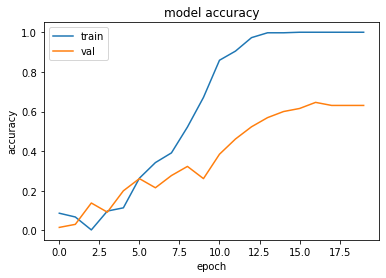

In [89]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

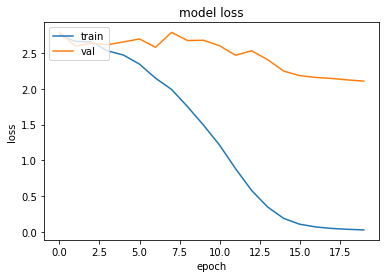

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [91]:
for acc in history.history['acc']:
    print(acc)

0.08695652
0.06793478
0.0027173914
0.097826086
0.11413044
0.26358697
0.3423913
0.39130434
0.5217391
0.6711956
0.8586956
0.9048913
0.97282606
0.9972826
0.9972826
1.0
1.0
1.0
1.0
1.0


In [92]:
for acc in history.history['val_acc']:
    print(acc)

0.015384615398943424
0.03076923079788685
0.13846154510974884
0.0923076942563057
0.20000000298023224
0.26153847575187683
0.2153846174478531
0.2769230902194977
0.32307693362236023
0.26153847575187683
0.38461539149284363
0.4615384638309479
0.5230769515037537
0.5692307949066162
0.6000000238418579
0.6153846383094788
0.6461538672447205
0.6307692527770996
0.6307692527770996
0.6307692527770996


In [93]:
for loss in history.history['loss']:
    print(loss)

2.7504666298627853
2.6613576230795486
2.6551616140033887
2.5297112464904785
2.4703906489455183
2.343522115893986
2.1475640172543735
1.990884541169457
1.7496749829986822
1.4908112170903578
1.2121541843466137
0.8831478065770605
0.5801885066472966
0.3492084052413702
0.19051131270016017
0.10906059037813026
0.07105996507300955
0.05037502217632921
0.03790627738825329
0.029659336260722383


In [94]:
for loss in history.history['val_loss']:
    print(loss)

2.7888903617858887
2.5946431159973145
2.6377925872802734
2.6141271591186523
2.6540305614471436
2.695359706878662
2.579244375228882
2.7866339683532715
2.6733667850494385
2.6769862174987793
2.599818468093872
2.4675731658935547
2.5301225185394287
2.405400037765503
2.2471413612365723
2.1830902099609375
2.1582655906677246
2.1442017555236816
2.1230244636535645
2.1068060398101807
